# Arbitrage Strategy Based on Book-to-Market

This notebook implements an arbitrage model based on the spread between accounting value (book value) and market value of major listed companies.
Enhancements include:
- Sector neutrality
- Transaction cost adjustments
- Combined value signals (Book-to-Market and Free Cash Flow Yield)
- Quality filtering (positive earnings, low accruals)

## Theoretical Framework

Let:
- $P_{i,t}$ = Price of stock *i* at time *t*
- $BVPS_{i,t}$ = Book Value per Share
- $MV_{i,t} = P_{i,t} \times Shares$
- $BV_{i,t} = BVPS_{i,t} \times Shares$

### Value Signal:
We consider book value to market capitalization ratio: how much accounting value is paid for by the market
$$
BTM_{i,t} = \frac{BV_{i,t}}{MV_{i,t}}
$$

### FCF Yield:
$$
FCFY_{i,t} = \frac{FCF_{i,t}}{MV_{i,t}}
$$

### Composite Signal (Z-Score):
$$
Z_{i,t} = \frac{(Signal_{i,t} - \mu_t)}{\sigma_t}
$$
Where $Signal_{i,t}$ combines BTM and FCFY, and $\mu_t$, $\sigma_t$ are cross-sectional mean and std.

We go **long** on stocks with high Z (strong book value or other fundamentals) and **short** on low Z, adjusted for sector neutrality.

In [ ]:
# Requirements and setup for the project
%pip install -r ./requirements.txt
!mkdir -p ./data
!if [ ! -f ./.env ]; then echo "Please create a .env file with your ALPHA_VANTAGE_API_KEY."; fi

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import date
import os
import random

from utils import get_fundamentals, load_fundamentals
from utils import compute_book_value_per_share, next_quarter
from utils import register_traffic_magic

register_traffic_magic()

In [ ]:
%%nettraffic
# CONFIG FOR AV + FETCH NEW DATA
# List of ticker info already possessed locally:
OLD_TICKERS = list(load_fundamentals()['ticker'].unique())

# void tickers on AV?: so far '1MC', 'KER', 'BRK.B', 'RGT', 

nyse = pd.read_csv('nasdaqtraded.txt', sep='|') # file available at ftp://ftp.nasdaqtrader.com/symboldirectory/
nyse = nyse[(nyse['Test Issue'] == 'N') & (nyse['ETF'] == 'N') # remove ETFs + tests
            & (~nyse['Symbol'].isin(OLD_TICKERS))] # need to exclude from the list all the ones that have already been added!

TICKERS = random.sample(list(nyse['Symbol']), 6) # AV usage limitations
print(f'Tickers: {TICKERS}')

function_map = {'b': 'BALANCE_SHEET', 'i': 'INCOME_STATEMENT', 'c': 'CASH_FLOW'}
fundamentals = {} # Comment this line to continue data fetching if connection resets

for ticker in TICKERS:
    overview = get_fundamentals(ticker, function='o')
    pd.DataFrame([overview]).to_csv(f'./data/archive/overview_{ticker}.csv', index=False)
    fundamentals[(ticker, 'current', 'OVERVIEW')] = overview

    for function in ['b', 'i', 'c']:
        reports = get_fundamentals(ticker, function=function)
        pd.DataFrame(reports).to_csv(f'./data/archive/{function}_{ticker}.csv', index=False)
        fundamentals.update({(ticker, report['fiscalDateEnding'], function_map[function]): report for report in reports})

# Convert the fundamentals dictionary to a DataFrame
fundamentals = {k: v for k, v in fundamentals.items() if v is not None}
df = pd.DataFrame(fundamentals).T
df.index.names = ['ticker', 'fiscalDateEnding', 'statementType']
df.drop(columns=['Symbol', 'fiscalDateEnding', 'statementType', 'index'], errors='ignore', inplace=True)
df.drop(columns=df.filter(regex=r"^Unnamed").columns, inplace=True, errors="ignore")
df.reset_index(inplace=True)

# Save data
os.makedirs(f'data/{date.today().isoformat()}', exist_ok=True)
df = load_fundamentals(df) # concat with previous data
df.to_csv(f'./data/{date.today().isoformat()}/fundamentals_{date.today().isoformat()}.csv')
# Save attributes
pd.DataFrame({'Attributes': df.columns.tolist()}).to_csv(f'./data/{date.today().isoformat()}/attributes_{date.today().isoformat()}.csv', index=False)

df = None  # Clear memory

Tickers: ['TBH', 'YAAS', 'RGT', 'KODK', 'PRSO', 'BAYAR']
0.96 MB inviati; 6.10 MB ricevuti.


In [3]:
# Prepare attributes + Check if same metrics are present in different statements
# Net Income appears in both income statement and cash flow statement; not always same values
b = pd.read_csv('./data/archive/b_AAPL.csv', index_col='fiscalDateEnding', parse_dates=True)
bc = b.columns.to_list()
i = pd.read_csv('./data/archive/i_AAPL.csv', index_col='fiscalDateEnding', parse_dates=True)
ic = i.columns.to_list()
c = pd.read_csv('./data/archive/c_AAPL.csv', index_col='fiscalDateEnding', parse_dates=True)
cc = c.columns.to_list()
o = pd.read_csv('./data/archive/overview_AAPL.csv', parse_dates=True)
oc = o.columns.to_list()

#print('Balance Sheet & Overview:', set(bc) & set(oc))
#print('Income & Overview:', set(ic) & set(oc))
#print('Cash Flow & Overview:', set(cc) & set(oc))
print('Balance Sheet & Income:', set(bc) & set(ic))
print('Balance Sheet & Cash Flow:', set(bc) & set(cc))
print('Income & Cash Flow:', set(ic) & set(cc))
# print(i[['netIncome']].iloc[-3:], c[['netIncome']].iloc[-3:])

Balance Sheet & Income: {'reportedCurrency'}
Balance Sheet & Cash Flow: {'reportedCurrency'}
Income & Cash Flow: {'reportedCurrency', 'netIncome'}


In [4]:
# Load the latest file
fundamentals = load_fundamentals()

# Remove rows with NaN values in all columns
fundamentals = fundamentals.dropna(how='all')

# Convert the DataFrame to numeric columns that start with a digit
#fundamentals = fundamentals.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.astype(str).str.contains(r'^\d', na=False).any() else x)
fundamentals = fundamentals.pivot_table(index=['ticker', 'fiscalDateEnding'], columns='statementType', values=bc + ic + cc + [col for col in oc if col not in ['Symbol']], aggfunc='first')
fundamentals.columns = fundamentals.columns.swaplevel(0, 1)
fundamentals.reset_index(inplace=True)
fundamentals = fundamentals.set_index(['ticker', 'fiscalDateEnding'])

# Filter out companies with negative EPS or profit margin
# We need keep any line with tickers s.t. its ('OVERVIEW','DilutedEPSTTM') column is > 0:
viable_tickers = fundamentals.where(
    (fundamentals['OVERVIEW']['DilutedEPSTTM'] > 0) & (fundamentals['OVERVIEW']['ProfitMargin'] > 0)
).index.get_level_values('ticker').unique()

fundamentals = fundamentals[fundamentals.index.get_level_values('ticker').isin(viable_tickers)]
# Calculate Book value per Share
fundamentals = compute_book_value_per_share(fundamentals)
fundamentals.head()

statementType                      OVERVIEW                                \
                        200DayMovingAverage 50DayMovingAverage 52WeekHigh   
ticker fiscalDateEnding                                                     
AAPL   2005-03-31                       NaN                NaN        NaN   
       2005-06-30                       NaN                NaN        NaN   
       2005-09-30                       NaN                NaN        NaN   
       2005-12-31                       NaN                NaN        NaN   
       2006-03-31                       NaN                NaN        NaN   

statementType                                                                 \
                        52WeekLow Address AnalystRatingBuy AnalystRatingHold   
ticker fiscalDateEnding                                                        
AAPL   2005-03-31             NaN     NaN              NaN               NaN   
       2005-06-30             NaN     NaN              NaN               NaN   
       2005-09-30             NaN     NaN              NaN               NaN   
       2005-12-31             NaN     NaN              NaN               NaN   
       2006-03-31             NaN     NaN              NaN               NaN   

statementType                                                     \
                        AnalystRatingSell AnalystRatingStrongBuy   
ticker fiscalDateEnding                                            
AAPL   2005-03-31                     NaN                    NaN   
       2005-06-30                     NaN                    NaN   
       2005-09-30                     NaN                    NaN   
       2005-12-31                     NaN                    NaN   
       2006-03-31                     NaN                    NaN   

statementType                                    ... BALANCE_SHEET  \
                        AnalystRatingStrongSell  ...   totalAssets   
ticker fiscalDateEnding                          ...                 
AAPL   2005-03-31                           NaN  ...  1.011100e+10   
       2005-06-30                           NaN  ...  1.048800e+10   
       2005-09-30                           NaN  ...  1.155100e+10   
       2005-12-31                           NaN  ...  1.418100e+10   
       2006-03-31                           NaN  ...  1.391100e+10   

statementType                                                       \
                        totalCurrentAssets totalCurrentLiabilities   
ticker fiscalDateEnding                                              
AAPL   2005-03-31             8.710000e+09            3.352000e+09   
       2005-06-30             9.042000e+09            3.123000e+09   
       2005-09-30             9.969000e+09            3.484000e+09   
       2005-12-31             1.169100e+10            5.060000e+09   
       2006-03-31             1.073000e+10            4.456000e+09   

statementType                                                   \
                        totalLiabilities totalNonCurrentAssets   
ticker fiscalDateEnding                                          
AAPL   2005-03-31           3.725000e+09          1.104000e+09   
       2005-06-30           3.667000e+09          1.112000e+09   
       2005-09-30           4.085000e+09          1.251000e+09   
       2005-12-31           5.801000e+09          2.019000e+09   
       2006-03-31           5.229000e+09          2.625000e+09   

statementType                                      INCOME_STATEMENT  \
                        totalNonCurrentLiabilities     totalRevenue   
ticker fiscalDateEnding                                               
AAPL   2005-03-31                      373000000.0     3.243000e+09   
       2005-06-30                      544000000.0     3.520000e+09   
       2005-09-30                      601000000.0     3.678000e+09   
       2005-12-31                      741000000.0     5.749000e+09   
       2006-03-31                      773000000.

In [ ]:
%%nettraffic

# set tickers to those contained in the full fundamentals loaded dataframe
TICKERS = fundamentals.index.get_level_values('ticker').unique().tolist()
START_DATE = '2005-06-30'
END_DATE = '2025-06-30'
TRANSACTION_COST = 0.01  # 1% per trade to be conservative

prices = yf.download(TICKERS, start=START_DATE, end=END_DATE)
close_prices = prices['Close']

book_values, fcf_yields, accruals, market_values, sectors, earnings = {}, {}, {}, {}, {}, {}

for ticker in TICKERS:
    
    firm_data = fundamentals.loc[ticker]
    sector = firm_data.loc[('current')][('OVERVIEW','Sector')]

    # Drop overview from firm_data
    firm_data = firm_data.drop(index='current', errors='ignore')

    # Get all fiscal periods except 'current' for this ticker
    dates = firm_data.index.get_level_values('fiscalDateEnding')
    dates = dates[dates != 'current']

    shares_outstanding = firm_data[('BALANCE_SHEET','commonStockSharesOutstanding')]
    shares_outstanding.index = pd.to_datetime(shares_outstanding.index)

    book_value_ps = firm_data[('BALANCE_SHEET','bookValuePerShare')]
    book_value_ps.index = pd.to_datetime(book_value_ps.index)

    total_assets = firm_data[('BALANCE_SHEET', 'totalAssets')]
    total_liabilities = firm_data[('BALANCE_SHEET', 'totalLiabilities')]

    # Earnings and cash flow
    earnings_series = firm_data[('INCOME_STATEMENT', 'netIncomeFromContinuingOperations')] # this or netIncome?
    op_cash = firm_data[('CASH_FLOW', 'operatingCashflow')]
    fcf = op_cash - firm_data[('CASH_FLOW', 'capitalExpenditures')]
    fcf.index = pd.to_datetime(fcf.index)

    # Ensure dates are datetime for alignment
    dates_dt = pd.to_datetime(dates)
    price_at_report = close_prices[ticker].reindex(dates_dt, method='ffill')
    price_at_report.index = pd.to_datetime(price_at_report.index)

    market_cap = shares_outstanding * price_at_report
    book_value = book_value_ps * shares_outstanding
    accrual = (earnings_series - op_cash) / total_assets
    fcf_yield = fcf / market_cap

    market_values[ticker] = market_cap
    book_values[ticker] = book_value
    fcf_yields[ticker] = fcf_yield
    earnings[ticker] = earnings_series
    accruals[ticker] = (earnings[ticker] - op_cash) / total_assets
    sectors[ticker] = sector

market_values = pd.DataFrame(market_values)
book_values = pd.DataFrame(book_values)
fcf_yields = pd.DataFrame.from_dict(fcf_yields)

btm = book_values / market_values
btm = btm.replace({np.inf: np.nan, -np.inf: np.nan}).dropna(how='all')

# BTM based signal
z_btm = btm.sub(btm.mean(axis=1), axis=0).div(btm.std(axis=1), axis=0).fillna(0)
# z_btm = z_btm.fillna(0) # No std-dev, so fill with 0? Perhaps distorts the signal

# FCFY based signal
z_fcf = fcf_yields.sub(fcf_yields.mean(axis=1), axis=0).div(fcf_yields.std(axis=1), axis=0).fillna(0)
#z_fcf = z_fcf.fillna(0) # No std-dev, so fill with 0

z_btm

### BtM-only based signal

In [8]:
z_sector_adj = z_btm.copy()
for date in z_btm.index:
    for sector in set(sectors.values()):
        tickers_in_sector = [ticker for ticker, sec in sectors.items() if sec == sector]
        if len(tickers_in_sector) >= 2:
            sector_mean = z_btm.loc[date, tickers_in_sector].mean()
            z_sector_adj.loc[date, tickers_in_sector] -= sector_mean

# Apply quality filters
quality = pd.Series(accruals).apply(lambda x: abs(x) < 0.25) & (earnings[ticker] > 0)
filtered_tickers = quality[quality].index

# for rebalancing every quarter
signal = z_sector_adj[filtered_tickers].shift(1)
signal = signal.reindex(close_prices.index).ffill()

# Assume we begin at an arbitrary date and never rebalance
DATE = '2011-06-30'
initial_signal = z_sector_adj.loc[DATE, filtered_tickers]
initial_signal = initial_signal / initial_signal.abs().sum() # normalize
signal_df = pd.DataFrame(index=close_prices.index, columns=initial_signal.index)
signal_df[:] = initial_signal.values

returns = close_prices[filtered_tickers].pct_change().loc[signal.index]
daily_return = (signal_df * returns).mean(axis=1)
daily_return = daily_return.loc[next_quarter(DATE):]
gross_return = (1 + daily_return).cumprod()
net_return = daily_return
net_return.loc[next_quarter(DATE)] -= TRANSACTION_COST # when th first return will be realized
net_cum_return = (1 + net_return).cumprod()

/var/folders/j8/q1yzzyh9341fx__dgh644b400000gn/T/ipykernel_32926/3090486746.py:24: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices[filtered_tickers].pct_change().loc[signal.index]


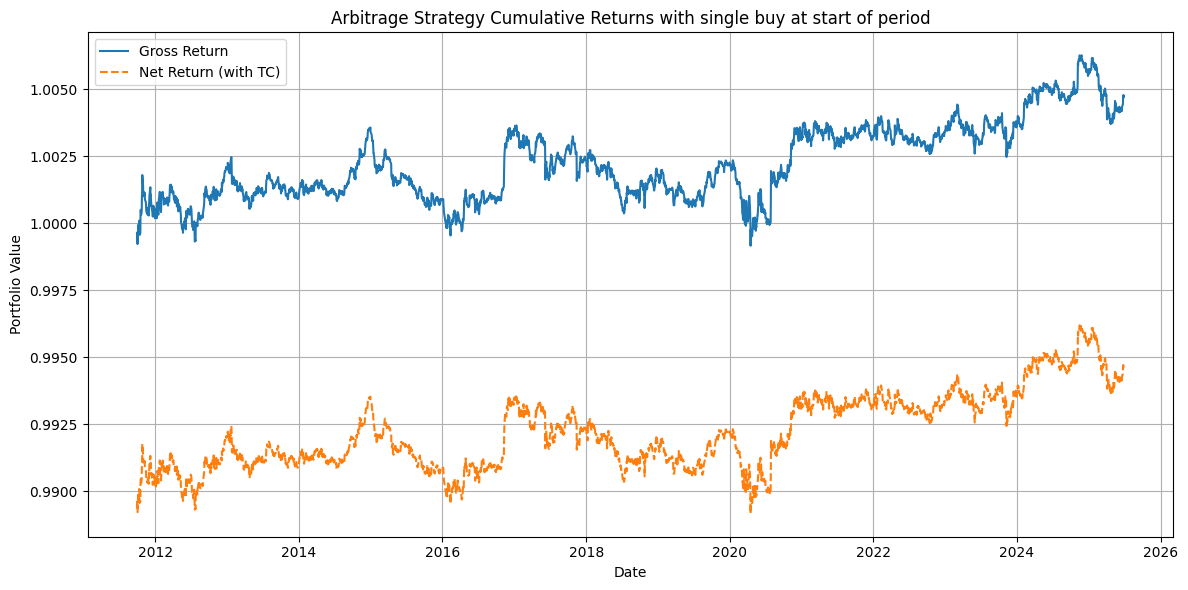

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(gross_return, label='Gross Return')
plt.plot(net_cum_return, label='Net Return (with TC)', linestyle='--')
plt.title("Arbitrage Strategy Cumulative Returns with single buy at start of period")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/j8/q1yzzyh9341fx__dgh644b400000gn/T/ipykernel_32926/251282579.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices[filtered_tickers].pct_change().loc[signal.index] # net, i.e. 0.xx


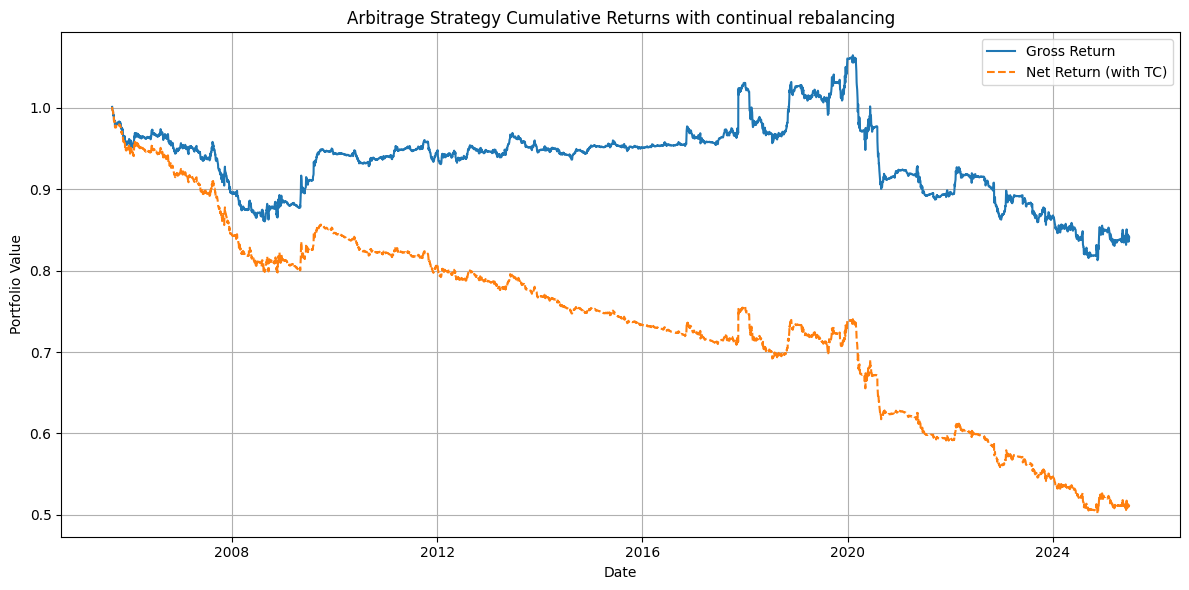

In [10]:
# If we want to rebalance continuously
TRANSACTION_COST = 0.0001  # 0.01% per trade, may be reasonable on large volumes?
signal = z_sector_adj[filtered_tickers].shift(1)
signal = signal.reindex(close_prices.index).ffill()

returns = close_prices[filtered_tickers].pct_change().loc[signal.index] # net, i.e. 0.xx
daily_return = (signal * returns).mean(axis=1)
gross_return = (1 + daily_return).cumprod()
net_return = daily_return - TRANSACTION_COST
net_cum_return = (1 + net_return).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(gross_return, label='Gross Return')
plt.plot(net_cum_return, label='Net Return (with TC)', linestyle='--')
plt.title("Arbitrage Strategy Cumulative Returns with continual rebalancing")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### FCFY-only based signal

In [11]:
z_sector_adj = z_fcf.copy()
for date in z_fcf.index:
    for sector in set(sectors.values()):
        tickers_in_sector = [ticker for ticker, sec in sectors.items() if sec == sector]
        if len(tickers_in_sector) >= 2:
            sector_mean = z_fcf.loc[date, tickers_in_sector].mean()
            z_sector_adj.loc[date, tickers_in_sector] -= sector_mean

# Apply quality filters
quality = pd.Series(accruals).apply(lambda x: abs(x) < 0.25) & (earnings[ticker] > 0)
filtered_tickers = quality[quality].index

# for rebalancing every quarter
signal = z_sector_adj[filtered_tickers].shift(1)
signal = signal.reindex(close_prices.index).ffill()

# Assume we begin at an arbitrary date and never rebalance
DATE = '2011-06-30'
initial_signal = z_sector_adj.loc[DATE, filtered_tickers]
initial_signal = initial_signal / initial_signal.abs().sum() # normalize
signal_df = pd.DataFrame(index=close_prices.index, columns=initial_signal.index)
signal_df[:] = initial_signal.values

returns = close_prices[filtered_tickers].pct_change().loc[signal.index]
daily_return = (signal_df * returns).mean(axis=1)
daily_return = daily_return.loc[next_quarter(DATE):]
gross_return = (1 + daily_return).cumprod()
net_return = daily_return
net_return.loc[next_quarter(DATE)] -= TRANSACTION_COST # when the first return will be realized
net_cum_return = (1 + net_return).cumprod()

/var/folders/j8/q1yzzyh9341fx__dgh644b400000gn/T/ipykernel_32926/1263111642.py:24: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices[filtered_tickers].pct_change().loc[signal.index]


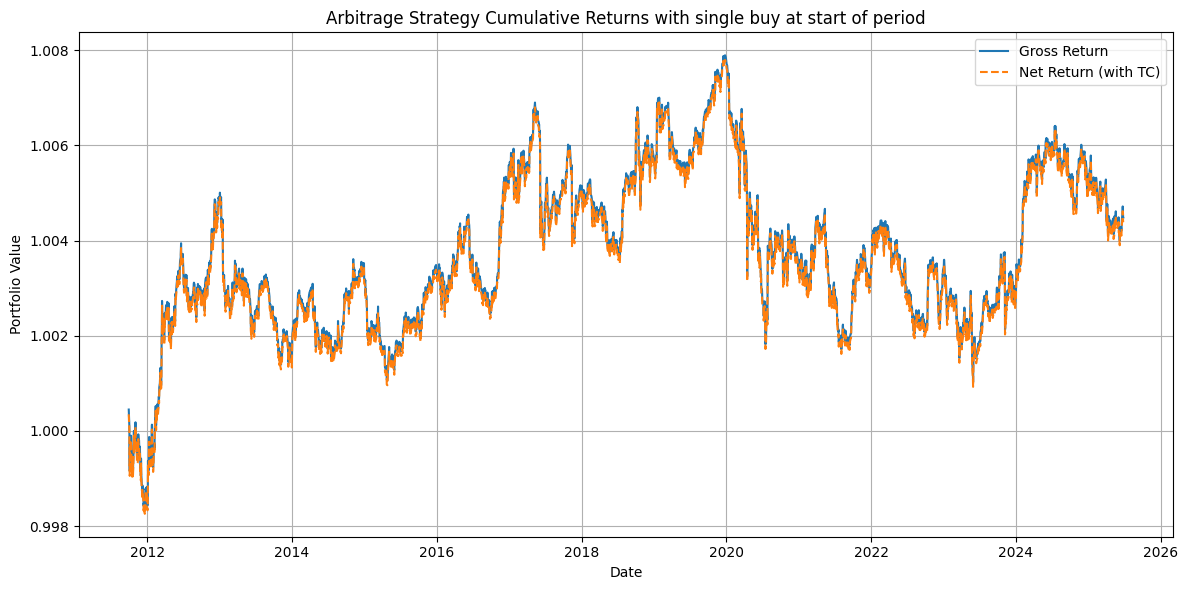

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(gross_return, label='Gross Return')
plt.plot(net_cum_return, label='Net Return (with TC)', linestyle='--')
plt.title("Arbitrage Strategy Cumulative Returns with single buy at start of period")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/j8/q1yzzyh9341fx__dgh644b400000gn/T/ipykernel_32926/251282579.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices[filtered_tickers].pct_change().loc[signal.index] # net, i.e. 0.xx


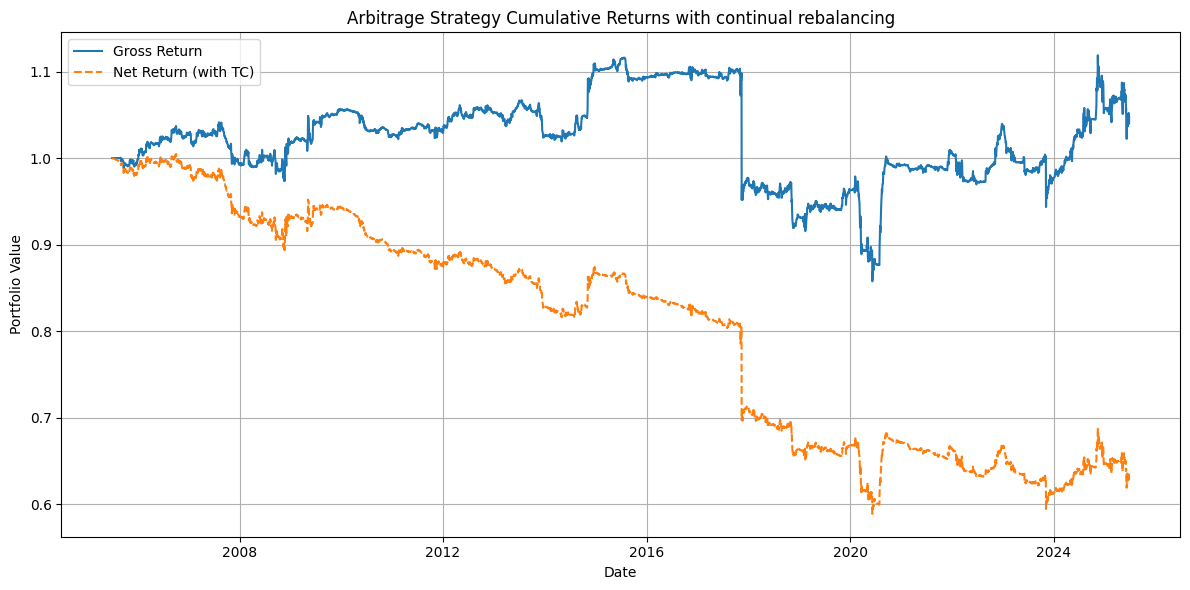

In [13]:
# If we want to rebalance continuously
TRANSACTION_COST = 0.0001  # 0.01% per trade, may be reasonable on large volumes?
signal = z_sector_adj[filtered_tickers].shift(1)
signal = signal.reindex(close_prices.index).ffill()

returns = close_prices[filtered_tickers].pct_change().loc[signal.index] # net, i.e. 0.xx
daily_return = (signal * returns).mean(axis=1)
gross_return = (1 + daily_return).cumprod()
net_return = daily_return - TRANSACTION_COST
net_cum_return = (1 + net_return).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(gross_return, label='Gross Return')
plt.plot(net_cum_return, label='Net Return (with TC)', linestyle='--')
plt.title("Arbitrage Strategy Cumulative Returns with continual rebalancing")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- For the tech sector alone a BTM-based strategy seemed to work very badly (even worse with rebalancing)! Diversifying among sector while ensuring sector neutrality of the signal improves the results.
- We can also see that the FCFY-based strategy performs better than the BTM one, at least if we do not consider the transaction cost.

One-time portfolio build:  AAPL    -0.003149
ABBV     0.004761
ABT      0.004761
AEO      0.008211
AI       0.003924
AMD      0.004827
AMZN    -0.025217
AVGO     0.004827
BAC      0.319767
BAYAR    0.000000
BUD     -0.005349
COST     0.008211
CRM      0.003924
CSCO     0.003924
CVX      0.001009
GE       0.004827
GOOG     0.003924
GOOGL    0.003924
GTLB     0.003924
HD       0.008211
IBM     -0.011724
INTU     0.003924
JNJ      0.004761
JPM     -0.053117
KO       0.004827
KODK     0.004761
LIN     -0.024851
LLY      0.005807
MA       0.008211
MCD      0.008211
META     0.003924
MS      -0.204311
MSFT    -0.008337
NFLX    -0.021381
NVDA     0.004827
ORCL     0.003924
PG      -0.017970
PLTR     0.003924
PM       0.015779
PRSO    -0.039392
TBH      0.008211
TMUS    -0.019957
TSLA     0.004827
UNH     -0.053117
V       -0.010880
WFC     -0.009223
WMT      0.008211
XOM     -0.001009
YAAS     0.003924
Name: 2011-06-30 00:00:00, dtype: float64


<Axes: title={'center': 'Average Portfolio Exposure'}, xlabel='Date'>

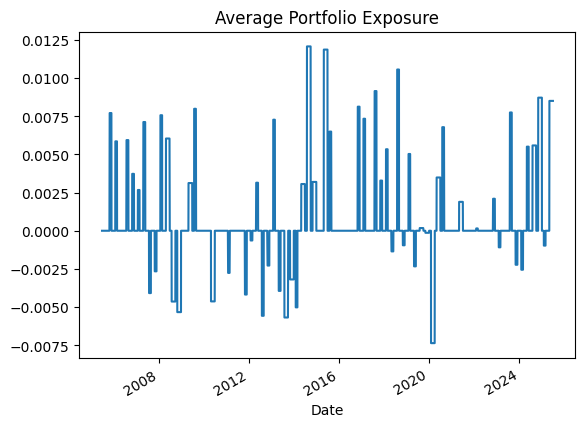

In [14]:
print("One-time portfolio build: ", initial_signal)

signal.mean(axis=1).plot(title="Average Portfolio Exposure")

## More complex regressions on fundamentals

Given that BTM does not appear to be a good signal by itself, below we should
- combine Free Cash Flow Yield and $BTM$ in a unique signal *only if* a more complex $BTM$-based signal which uses all the past available information for each time period were to perform better; otherwise, we can improve the $FCFY$ signal alone by including the past history and see if results improve
- try price regression and ML approaches on fundamentals rather than raw signal based on only one or two variables

/var/folders/j8/q1yzzyh9341fx__dgh644b400000gn/T/ipykernel_32926/4020090887.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  firm_data = fundamentals[fundamentals.index.get_level_values('fiscalDateEnding') != 'current'].copy().drop(


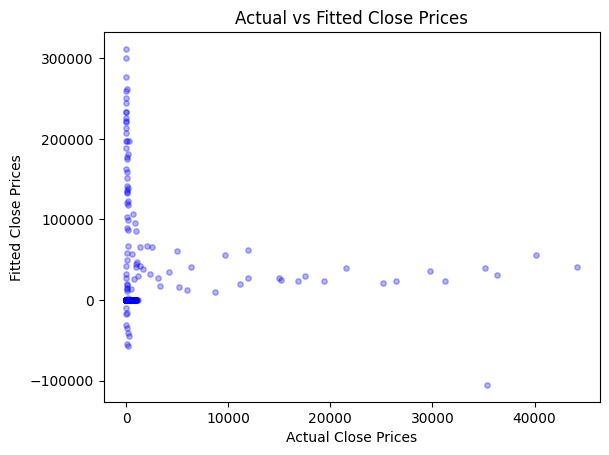

In [70]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

firm_data = fundamentals[fundamentals.index.get_level_values('fiscalDateEnding') != 'current'].copy().drop(
    columns=[
        ('INCOME_STATEMENT','reportedCurrency'), 
        ('BALANCE_SHEET','reportedCurrency'),
        ('CASH_FLOW','reportedCurrency'),
        'OVERVIEW'])

# Reorder headers and align data
firm_data = firm_data.unstack(level=0)
firm_data.columns = firm_data.columns.swaplevel(0, 2)
firm_data.columns = firm_data.columns.swaplevel(1, 2)
firm_data.index = pd.to_datetime(firm_data.index)

# Reload close prices and drop firms for which there is no data for the selected time period (may be narrowed if needed)
close_prices = prices['Close']
close_prices = close_prices[filtered_tickers].dropna(axis=1, how='any')
firm_data = firm_data[close_prices.columns]
firm_data = firm_data.fillna(0)

common_idx = close_prices.index.intersection(firm_data.index)
close_prices = close_prices.loc[common_idx]
firm_data = firm_data.loc[common_idx]
close_prices = close_prices.sort_index()
firm_data = firm_data.sort_index()

close_prices_train, close_prices_test = close_prices.iloc[:-100], close_prices.iloc[-100:]
firm_data_train, firm_data_test = firm_data.iloc[:-100], firm_data.iloc[-100:]

reg.fit(firm_data_train, close_prices_train)
close_prices_fit = reg.predict(firm_data_test)

plt.scatter(close_prices_test, close_prices_fit, alpha=0.3, color='blue', s=15)

plt.xlabel('Actual Close Prices')
plt.ylabel('Fitted Close Prices')
plt.title('Actual vs Fitted Close Prices')
plt.show()

There is definitely room for improvement! A first step is to use the KNN imputer to improve the NaN fill in firm_data, since setting all =0 distorts the linear model significantly.
However, the KNN Imputer currently alters the shape of the firm_data dataframe in an unintelligible way, hence a more sophisticated approach is required.